## Download a GeoTIFF tile from OpenTopography and display it.


{'north': -9.74, 'south': -9.94, 'east': -67.069, 'west': -67.26899999999999}
Saved raster tile to /home/ziggy/dev/oaiarch/tile.tif


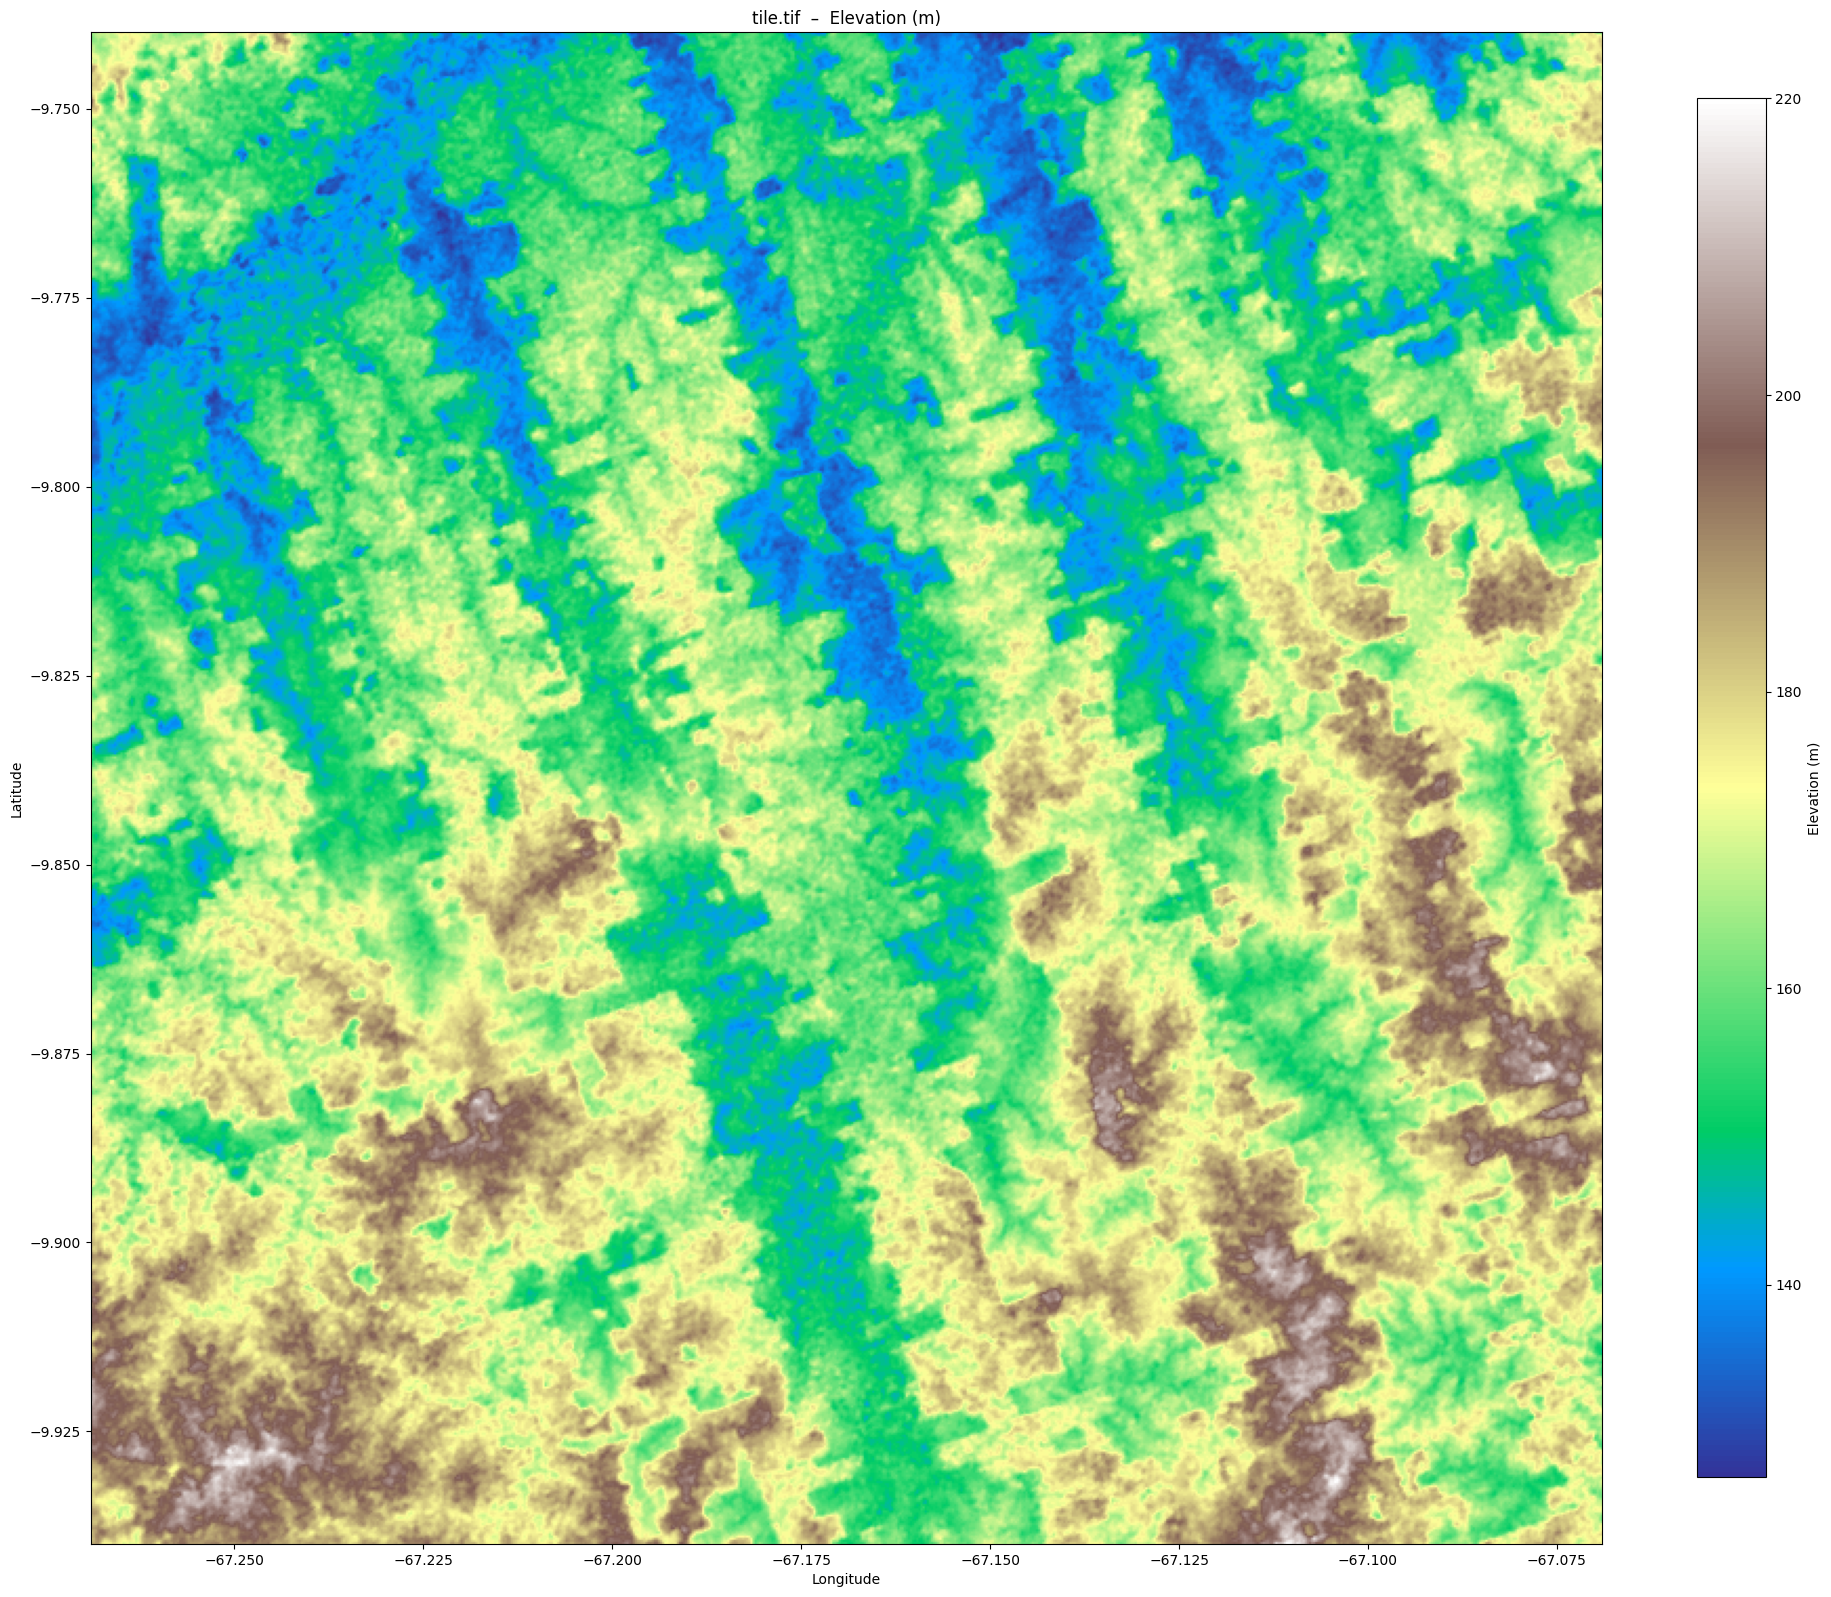

In [ ]:
"""
Download a GeoTIFF tile from OpenTopography and display it.

Dependencies
------------
pip install requests rasterio matplotlib
"""
from __future__ import annotations

import io
import sys
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import requests

from pyproj import Transformer
from dotenv import load_dotenv
import os
load_dotenv()

def convert_utm_to_wgs84(utm_x, utm_y):
    # Define the transformer: from UTM zone 19S (EPSG:32719) to WGS 84 (EPSG:4326)
    transformer = Transformer.from_crs("EPSG:32719", "EPSG:4326", always_xy=True)

    # Convert to latitude and longitude
    lon, lat = transformer.transform(utm_x, utm_y)

    return lon, lat


def fetch_raster_tile_from_opentopography(
    api_key: str,
    dataset: str,
    north: float,
    south: float,
    east: float,
    west: float,
    dest: Path = Path("tile.tif"),
    source: str = "globaldem"
) -> Path:
    """
    Download a GeoTIFF tile from OpenTopography’s Point-Cloud API.

    Returns
    -------
    Path
        Path to the downloaded `.tif` file (possibly extracted from a ZIP).
    """
    outputFormat = "GTiff"
    ds_key = ""
    if source == "usgsdem":
        ds_key = "datasetName"
    elif source == "globaldem":
        ds_key = "demtype"
    else:
        raise ValueError(f"Invalid source: {source}")
    url = f"https://portal.opentopography.org/API/{source}?{ds_key}={dataset}&north={str(north)}&south={str(south)}&east={str(east)}&west={str(west)}&outputFormat={outputFormat}&API_Key={api_key}"

    # print("Requesting data from ", url)

    r = requests.get(url,  timeout=300)
    if (len(r.content) < 200):
        print(r.content)
    r.raise_for_status()

    # The service may send back either a bare .tif or a ZIP archive.
    content_type = r.headers.get("content-type", "")
    if "zip" in content_type or r.content[:2] == b"PK":
        with zipfile.ZipFile(io.BytesIO(r.content)) as zf:
            tif_name = next(n for n in zf.namelist() if n.lower().endswith(".tif"))
            zf.extract(tif_name, dest.parent)
            dest = dest.parent / tif_name
    else:
        dest.write_bytes(r.content)

    print(f"Saved raster tile to {dest.resolve()}")
    return dest


def display_raster(path: Path) -> None:
    """Render the GeoTIFF elevation raster with matplotlib."""
    with rasterio.open(path) as src:
        data = src.read(1, masked=True)  # first band
        bounds = src.bounds

    fig, ax = plt.subplots(figsize=(20, 20))
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    im = ax.imshow(
        data, cmap="terrain", extent=extent, origin="upper"
    )
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{path.name}  –  Elevation (m)")
    cbar = fig.colorbar(im, ax=ax, shrink=0.7)
    cbar.set_label("Elevation (m)")
    plt.tight_layout()
    plt.show()

api_key = os.environ.get("OPENTOPOGRAPHY_API_KEY")

# Example parameters; change these to suit your AOI
boa_espar = (700753,	8911712	)
center = convert_utm_to_wgs84(boa_espar[0], boa_espar[1])
center = (center[0].__round__(3), center[1].__round__(3))
# center = (40.0,15.0)
radius = 0.1
east = center[0] + radius
west = center[0] - radius
north = center[1] + radius
south = center[1] - radius
print({
    "north": north,
    "south": south,
    "east": east,
    "west": west
})
dataset = "SRTMGL1"

out_path_1 = fetch_raster_tile_from_opentopography(api_key, dataset, north, south, east, west, source="globaldem")
display_raster(out_path_1)
# out_path_2 = fetch_raster_tile(api_key, dataset, north+0.1, south, east, west)
# display_raster(out_path_2)

## Send tif Data to OpenAI

In [3]:
from typing import Tuple
import base64
from openai import OpenAI
import os

def raster_to_png_data_url(
    tif_path: Path, size: Tuple[int, int] = (512, 512)
) -> str:
    """
    Down-sample the first band of the GeoTIFF, scale to 8-bit, and
    return a data-URL (PNG, base-64) suitable for the OpenAI vision API.
    """
    with rasterio.open(tif_path) as src:
        data = src.read(1, masked=True).astype(np.float32)

    # Simple min-max stretch → 0-255
    z_min, z_max = np.nanmin(data), np.nanmax(data)
    arr = np.clip((data - z_min) / (z_max - z_min + 1e-9) * 255, 0, 255).astype(
        np.uint8
    )

    # Resize to something manageable for the API
    fig = plt.figure(frameon=False)
    fig.set_size_inches(*[s / 100 for s in size])
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(arr, cmap="gray", origin="upper")
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    plt.close(fig)

    png_base64 = base64.b64encode(buf.getvalue()).decode("ascii")
    return f"data:image/png;base64,{png_base64}"

def analyse_with_openai(
    image_data_url: str,
    prompt: str = "Describe the major terrain / geomorphological features visible in this elevation raster.",
    model: str = "o4-mini",
    max_tokens: int = 400,
) -> str:
    """
    Send an image + prompt to GPT-4o’s vision endpoint and return the text.
    """
    client = OpenAI()  # picks up OPENAI_API_KEY from env
    print("→ Contacting OpenAI …")
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": image_data_url, "detail": "high"}},
                ],
            }
        ],
        # max_tokens=max_tokens,
    )
    return completion.choices[0].message.content.strip()

data_url = raster_to_png_data_url(out_path_1)

analysis = analyse_with_openai(data_url)

→ Contacting OpenAI …


In [4]:
print(analysis)

The most striking thing about this little DEM “snapshot” is that it is not a random hummocky surface, but instead a beautifully regular series of linear ridges and valleys.  In broad terms you can see:  

 1. Parallel Ridges and Valleys  
    • The high‐ground and low‐ground both form long, narrow bands that all run in roughly the same direction (in this view it’s approximately NE–SW).  
    • The ridges are quite narrow, typically only a few hundred metres across in the image, and stand out clearly against the intervening troughs.  

 2. Asymmetric Cross–Sections (Cuestas/Hogbacks)  
    • Many of the ridges have one side that drops off more steeply (the “scarp”) and an opposite side that slopes more gently (“dip slope”).  This is the classic signature of resistant and non-resistant sedimentary beds being tilted and then differentially eroded.  
    • The steep scarps show up as fairly sharp tonal contrasts in the DEM, whereas the dip slopes fade more gradually.  

 3. Trellis-Type Dr

## Display LiDAR data

In [6]:
import laspy
import numpy as np
import plotly.graph_objects as go

path_prefix = '/mnt/datasets/lidar_nasa/orders/926ea6cc8cdee77c3ed86112e89c08f5/LiDAR_Forest_Inventory_Brazil/data'

# Load the LAZ file
las = laspy.read(path_prefix + "/ST2_A01_2013_laz_13.laz")

# Extract coordinates
x = las.x
y = las.y
z = las.z

# Optional: downsample for performance
sample_indices = np.random.choice(len(x), size=min(100000, len(x)), replace=False)
x = x[sample_indices]
y = y[sample_indices]
z = z[sample_indices]

# Optional: use color if available
if hasattr(las, 'red') and hasattr(las, 'green') and hasattr(las, 'blue'):
    r = las.red[sample_indices] / 65535.0
    g = las.green[sample_indices] / 65535.0
    b = las.blue[sample_indices] / 65535.0
    colors = ['rgb({},{},{})'.format(int(r[i]*255), int(g[i]*255), int(b[i]*255)) for i in range(len(r))]
else:
    colors = z  # Color by height

# Create Plotly 3D scatter plot
fig = go.Figure(data=[
    go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=1.5,
            color=colors,  # Either RGB or scalar z values
            colorscale='Viridis' if isinstance(colors[0], (float, np.float64)) else None,
            opacity=0.8
        )
    )
])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ),
    title="LAZ Point Cloud",
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


## Explore Brazil LiDAR Data

In [64]:
import pandas as pd

rects_df1 = pd.read_csv(path_prefix+'/cms_brazil_lidar_tile_inventory.csv')

In [65]:
locations = pd.read_csv('locations.csv')

def is_in_rect (min_lat, min_lon, max_lat, max_lon, lat, lon):
    return min_lat <= lat <= max_lat and min_lon <= lon <= max_lon

def measure(lat1, lon1, lat2, lon2):
    R = 6378.137  # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d * 1000  # meters

max_lat = rects_df1['max_lat'].max()
min_lat = rects_df1['min_lat'].min()
max_lon = rects_df1['max_lon'].max()
min_lon = rects_df1['min_lon'].min()

for i, row in locations.iterrows():
    x = row["x (UTM 19S)"]
    y = row["y (UTM 19S)"]
    lon, lat = convert_utm_to_wgs84(x, y)
    # if is_in_rect(min_lat, min_lon, max_lat, max_lon, lat, lon):
    #     print(f"Location {i} ({lon}, {lat}) is in the area of interest.")
    min_dist = 100000
    if(sum(df.apply(lambda row: is_in_rect(
        row['min_lat'], row['min_lon'], row['max_lat'], row['max_lon'],
        lat, lon
    ), axis=1).astype(int))) > 0:
        print(f"Location {i} ({lon}, {lat}) is in the area of interest.")
    else:
        # print(f"Location {i} ({lon}, {lat}) is NOT in the area of interest.")
        for j, row in rects_df1.iterrows():
            dist = measure(lat, lon, ((row['min_lat'] + row['max_lat']) / 2), ((row['min_lon'] + row['max_lon']) / 2))
            if dist < min_dist:
                min_dist = dist
        print(f"Closest tile has distance {min_dist}")


Closest tile has distance 22493.01561279689
Closest tile has distance 12746.82596529049
Closest tile has distance 6091.418838540096
Closest tile has distance 30284.044860974773
Closest tile has distance 29809.889965666614
Closest tile has distance 14599.362185076781
Closest tile has distance 14094.175551027642
Closest tile has distance 23159.714085289197
Closest tile has distance 22147.672245386206
Closest tile has distance 11754.866020264179
Closest tile has distance 22127.39810225144
Closest tile has distance 10542.456070155553
Closest tile has distance 20622.666556417753
Closest tile has distance 46206.51286917486
Closest tile has distance 46442.92362458514
Closest tile has distance 46597.40759972237
Closest tile has distance 21633.685727423977
Closest tile has distance 18017.241561778836
Closest tile has distance 10222.82367128146
Closest tile has distance 38343.365775028695
Closest tile has distance 29553.96984571322
Closest tile has distance 50744.46263413651
Closest tile has dis

In [66]:
rects_df2 = pd.read_csv('cms_brazil_lidar_2.csv')
rects_df2.columns

Index(['SURVEY', 'FILENAME', 'SOFTWARE', 'NUM_PTS', 'NUM_RET1', 'NUM_RET2',
       'NUM_RET3', 'NUM_RET4', 'NUM_RET5', 'X_SF', 'Y_SF', 'Z_SF', 'X_MIN',
       'Y_MIN', 'X_MAX', 'Y_MAX', 'Z_MIN', 'Z_MAX', 'LONG_MIN', 'LAT_MIN',
       'LONG_MAX', 'LAT_MAX', 'COMPRESSION', 'INTENSITY_MIN', 'INTENSITY_MAX',
       'NUM_RET_MIN', 'NUM_RET_MAX', 'NUM_GROUND', 'NUM_LOWVEG', 'NUM_MEDVEG',
       'NUM_HIVEG'],
      dtype='object')

In [69]:
for i, row in locations.iterrows():
    x = row["x (UTM 19S)"]
    y = row["y (UTM 19S)"]
    lon, lat = convert_utm_to_wgs84(x, y)
    min_dist = 10000000
    if(sum(rects_df2.apply(lambda row: is_in_rect(
        row['LAT_MIN'], row['LONG_MIN'], row['LAT_MAX'], row['LONG_MAX'],
        lat, lon
    ), axis=1).astype(int))) > 0:
        print(f"Location {i} ({lon}, {lat}) is in the area of interest.")
    else:
        # print(f"Location {i} ({lon}, {lat}) is NOT in the area of interest.")
        for j, row in rects_df2.iterrows():
            dist = measure(lat, lon, ((row['LAT_MIN'] + row['LAT_MAX']) / 2), ((row['LONG_MIN'] + row['LONG_MAX']) / 2))
            if dist < min_dist:
                min_dist = dist
        print(f"Closest tile has distance {min_dist}")

Closest tile has distance 2163186.646734469
Closest tile has distance 2170894.205302072
Closest tile has distance 2192271.3252928704
Closest tile has distance 2234433.992477616
Closest tile has distance 2233827.0785714863
Closest tile has distance 2171389.7477313876
Closest tile has distance 2171922.5291825314
Closest tile has distance 2227051.426037658
Closest tile has distance 2226560.054747479
Closest tile has distance 2171442.758256579
Closest tile has distance 2204387.459030878
Closest tile has distance 2174259.579588374
Closest tile has distance 2194779.160724361
Closest tile has distance 2243158.7344731716
Closest tile has distance 2243065.5771416845
Closest tile has distance 2242067.7303717076
Closest tile has distance 2224473.3677285
Closest tile has distance 2220180.122377464
Closest tile has distance 2196170.5413814974
Closest tile has distance 2206613.339182513
Closest tile has distance 2183063.218579512
Closest tile has distance 2215093.7129463567
Closest tile has distance

In [13]:
pd.set_option('display.max_colwidth', None)
print(df.iloc[0].to_string())

filename                                                                  ANA_A01_2017_laz_0.laz
max_lat                                                                                -3.363488
min_lat                                                                                -3.372548
max_lon                                                                               -54.992912
min_lon                                                                               -55.001927
file_type                                                                             pointcloud
file_size_mb                                                                           85.374953
file_format                                                                              LAS/LAZ
version                                                                                      1.2
created                                                                                 214/2017
utmzone                       

In [15]:
list(filter(lambda f: f.endswith('.csv'), os.listdir(path_prefix)))

['cms_brazil_lidar_tile_inventory.csv']

In [16]:
len(df)

3152

In [17]:
len(os.listdir(path_prefix))

3154

In [ ]:
from zipfile import ZipFile
from fastkml import kml


kmz_path = path_prefix+'/cms_brazil_lidar_tile_inventory.kmz'

# Step 1: List contents
with ZipFile(kmz_path, 'r') as kmz:
    print("Files in KMZ:")
    for name in kmz.namelist():
        print(name)

correct_kml_path = 'cms_brazil_lidar_tile_inventory.kml'  # Replace with actual name printed above



Files in KMZ:
cms_brazil_lidar_tile_inventory.kml
